In [18]:
!git clone https://github.com/colome8/DAE-VAE.git

fatal: destination path 'DAE-VAE' already exists and is not an empty directory.


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PREPROCESAMIENTO

In [20]:
!pip install --upgrade wandb

In [29]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
# Install wandb with Keras support:
import wandb
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger
import getpass

In [22]:
# Definir parámetros
IMG_SIZE = (128, 128)  # Tamaño estándar de imagen
DATASET_PATH = "/content/DAE-VAE/filtered_images"  # Ruta en Google Colab

# CLAHE (Equalización adaptativa del histograma)
def clahe_equalization(img):
    img_uint8 = (img * 255).astype(np.uint8)  # Asegurar formato correcto
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final.astype(np.float32) / 255.0

# Función para cargar y preprocesar imágenes
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0  # Normalización (0-1)
            img_eq = clahe_equalization(img_array)  # Equalización de histograma
            images.append(img_eq)
            labels.append(label)
        except Exception as e:
            print(f"Error cargando imagen {filename}: {e}")
    return images, labels

# Cargar imágenes de ambas clases
apples_images, apples_labels = load_images_from_folder(os.path.join(DATASET_PATH, "apples"), label=0)
bananas_images, bananas_labels = load_images_from_folder(os.path.join(DATASET_PATH, "bananas"), label=1)

# Combinar datos
X = np.array(apples_images + bananas_images)
y = np.array(apples_labels + bananas_labels)

# Dividir en conjunto de entrenamiento (70%), validación (15%) y prueba (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Guardar datos preprocesados en formato .npz
np.savez_compressed("/content/preprocessed_dataset.npz", X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

print("Preprocesamiento completado. Dataset guardado como 'preprocessed_dataset.npz'")


Preprocesamiento completado. Dataset guardado como 'preprocessed_dataset.npz'


---
## DAE

In [23]:
# 🔐 Login y setup de W&B
WANDB_API_KEY = getpass.getpass("Ingresa tu W&B API Key (oculto): ")
wandb.login(key=WANDB_API_KEY)
wandb.init(project="DAE-VAE",
    name="DAE-Gaussian-Noise")

Ingresa tu W&B API Key (oculto): ··········


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [24]:
def add_noise(images, noise_type="gaussian", mean=0, var=0.01, salt_prob=0.02, pepper_prob=0.02):
    noisy = []
    for img in images:
        if noise_type == "gaussian":
            row, col, ch = img.shape
            sigma = var ** 0.5
            gauss = np.random.normal(mean, sigma, (row, col, ch))
            noisy_img = img + gauss
            noisy_img = np.clip(noisy_img, 0, 1)

        elif noise_type == "salt_pepper":
            noisy_img = np.copy(img)
            total_pixels = img.shape[0] * img.shape[1]
            num_salt = int(total_pixels * salt_prob)
            coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
            noisy_img[coords[0], coords[1], :] = 1
            num_pepper = int(total_pixels * pepper_prob)
            coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
            noisy_img[coords[0], coords[1], :] = 0

        else:
            noisy_img = img  # no noise
        noisy.append(noisy_img)
    return np.array(noisy)


In [25]:
# 📦 Agregar ruido a las imágenes
X_train_noisy = add_noise(X_train, noise_type="gaussian")
X_val_noisy   = add_noise(X_val, noise_type="gaussian")
X_test_noisy  = add_noise(X_test, noise_type="gaussian")


In [26]:
def build_autoencoder(input_shape=(128, 128, 3)):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    autoencoder = keras.Model(inputs, decoded)
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.compile(optimizer="adam", loss="mse")


In [30]:
# Asume que ya tienes: X_train, X_val, X_train_noisy, X_val_noisy
history = autoencoder.fit(
    X_train_noisy, X_train,
    validation_data=(X_val_noisy, X_val),
    epochs=10,
    batch_size=32,
    callbacks=[WandbMetricsLogger()]
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 497ms/step - loss: 0.1009 - val_loss: 0.0533
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0486 - val_loss: 0.0354
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0336 - val_loss: 0.0244
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0244 - val_loss: 0.0208
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0204 - val_loss: 0.0184
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0184 - val_loss: 0.0161
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0152 - val_loss: 0.0139
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0140 - val_loss: 0.0129


In [31]:
autoencoder.save("dae_model.keras")
wandb.save("dae_model.keras")

['/content/wandb/run-20250322_053224-c8103wii/files/dae_model.keras']

In [32]:
import matplotlib.pyplot as plt

def mostrar_resultados(idx=0):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Imagen original
    axs[0].imshow(X_test[idx])
    axs[0].set_title("Original")
    axs[0].axis("off")

    # Imagen con ruido
    axs[1].imshow(X_test_noisy[idx])
    axs[1].set_title("Con ruido")
    axs[1].axis("off")

    # Imagen restaurada por el modelo
    restored = autoencoder.predict(X_test_noisy[idx:idx+1])[0]
    axs[2].imshow(restored)
    axs[2].set_title("Restaurada")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


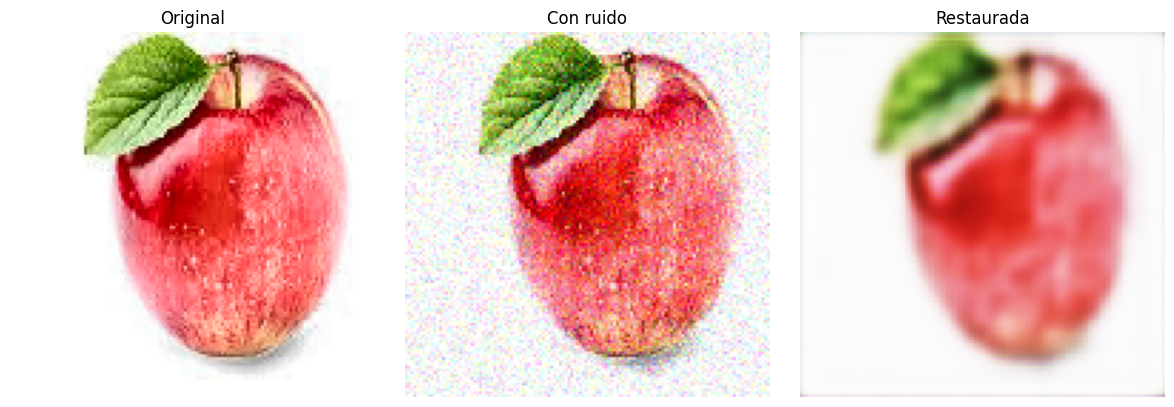

In [33]:
mostrar_resultados(81)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


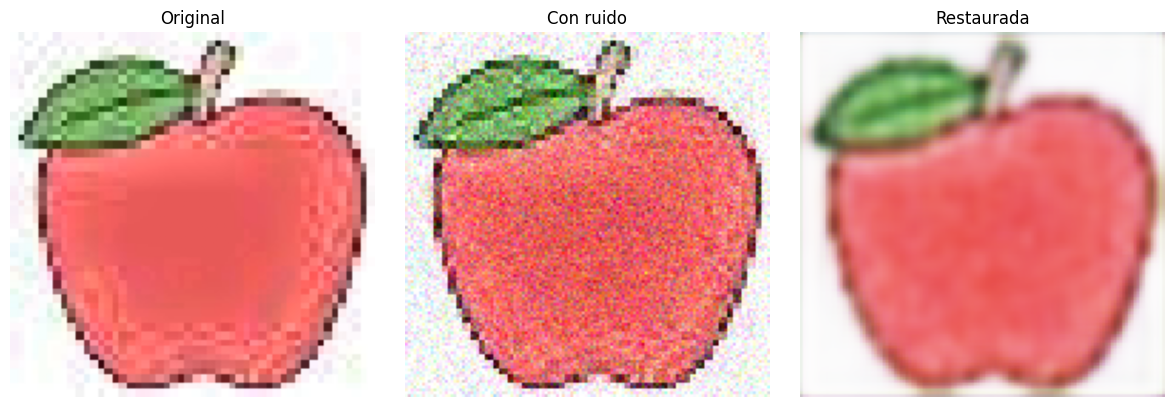

In [34]:
mostrar_resultados(5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


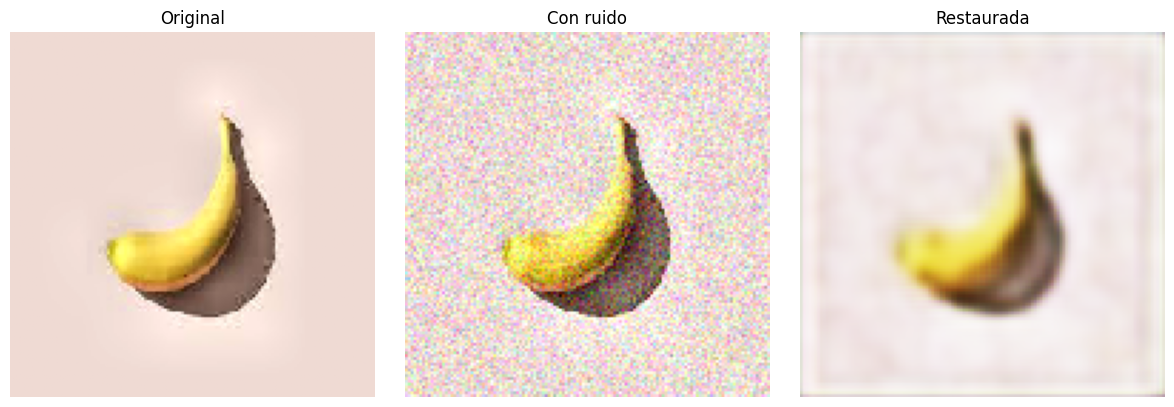

In [35]:
mostrar_resultados(64)

---
## VAE

In [37]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# -------------------------------
# 1. Configurar W&B
# -------------------------------
WANDB_API_KEY = getpass.getpass("🔑 Ingresa tu W&B API Key (oculto): ")
wandb.login(key=WANDB_API_KEY)
wandb.init(project="DAE-VAE", name="VAE")

# -------------------------------
# 2. Función FID
# -------------------------------
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def resize_images_for_fid(images):
    images_resized = tf.image.resize(images, (299, 299))
    return preprocess_input(images_resized)

def calculate_fid(real_images, generated_images):
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
    generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)
    real_images_pp = resize_images_for_fid(real_images)
    gen_images_pp = resize_images_for_fid(generated_images)
    act1 = inception_model.predict(real_images_pp, batch_size=32, verbose=0)
    act2 = inception_model.predict(gen_images_pp, batch_size=32, verbose=0)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# -------------------------------
# 3. Parámetros y modelo
# -------------------------------
LATENT_DIM = 16
INPUT_SHAPE = (128, 128, 3)
encoder_inputs = Input(shape=INPUT_SHAPE)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = Input(shape=(LATENT_DIM,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# -------------------------------
# 4. Definición del VAE
# -------------------------------
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer, **kwargs):
        super(VAE, self).compile(loss=lambda y_true, y_pred: 0, optimizer=optimizer, **kwargs)
        self.optimizer = optimizer
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, inputs, training=None, mask=None):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

# -------------------------------
# 5. Callback para imágenes y FID
# -------------------------------
class ImageLoggerCallback(keras.callbacks.Callback):
    def __init__(self, decoder, latent_dim, real_images):
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.real_images = real_images

    def on_epoch_end(self, epoch, logs=None):
        z_sample = tf.random.normal(shape=(100, self.latent_dim))
        generated = self.decoder.predict(z_sample)
        fid = calculate_fid(self.real_images[:100], generated[:100])
        wandb.log({
            "sampled_image": wandb.Image(generated[0], caption=f"Epoch {epoch + 1}"),
            "FID": fid
        })

# -------------------------------
# 6. Preparar y compilar VAE
# -------------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# -------------------------------
# 7. Entrenamiento
# -------------------------------
vae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=10,
    batch_size=32,
    callbacks=[
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath=os.path.join(checkpoint_dir, "vae_epoch_{epoch:02d}.keras"), save_best_only=False),
        ImageLoggerCallback(decoder=decoder, latent_dim=LATENT_DIM, real_images=X_test)
    ]
)

# -------------------------------
# 8. Guardar modelos
# -------------------------------
encoder.save("vae_encoder.keras")
decoder.save("vae_decoder.keras")
print("✅ ¡Entrenamiento finalizado y modelos guardados!")


🔑 Ingresa tu W&B API Key (oculto): ··········


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - kl_loss: 56.7663 - loss: 11132.7588 - reconstruction_loss: 11075.9922

/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         super(VAE, self).compile(loss=lambda y_true, y_pred: 0, optimizer=optimizer, **kwargs)

  return {key: serialize_keras_object(value) for key, value in obj.items()}


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


14/14 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - kl_loss: 57.4948 - loss: 11118.8613 - reconstruction_loss: 11061.3662 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - kl_loss: 88.2675 - loss: 10228.3418 - reconstruction_loss: 10140.0742 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 849ms/step - kl_loss: 57.0642 - loss: 9336.7197 - reconstruction_loss: 9279.6553 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - kl_loss: 30.6514 - loss: 9304.0518 - reconstruction_loss: 9273.4004 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconst

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


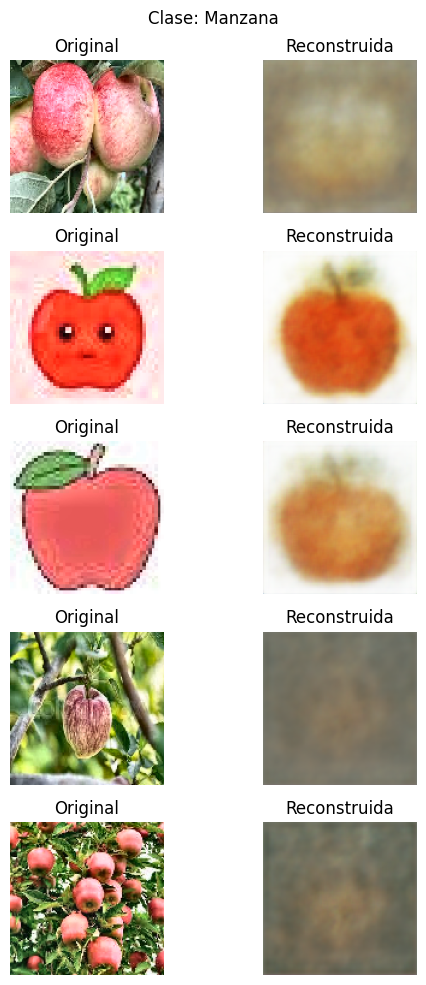

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


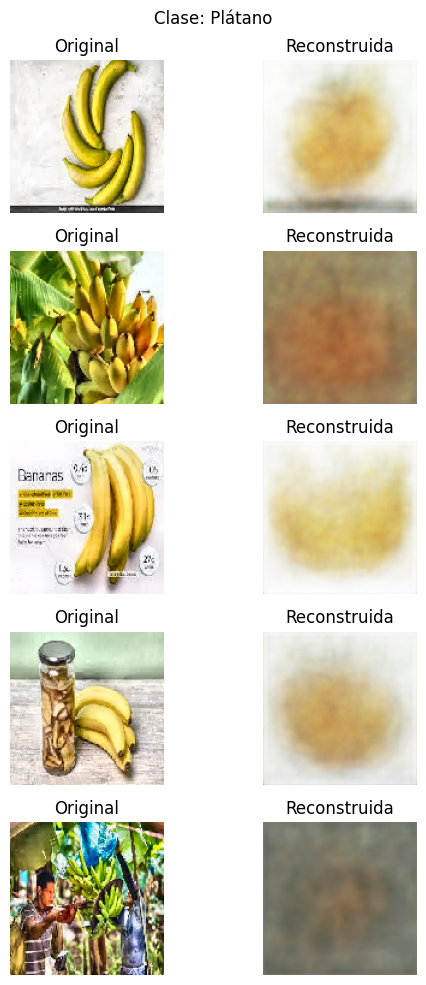

In [38]:
import matplotlib.pyplot as plt

def mostrar_imagenes_por_clase(vae, X, y, clase=0, cantidad=5):
    indices = np.where(y == clase)[0][:cantidad]
    imagenes = X[indices]
    reconstrucciones = vae.predict(imagenes)

    fig, axs = plt.subplots(cantidad, 2, figsize=(6, cantidad * 2))

    for i in range(cantidad):
        axs[i, 0].imshow(imagenes[i])
        axs[i, 0].set_title("Original")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(reconstrucciones[i])
        axs[i, 1].set_title("Reconstruida")
        axs[i, 1].axis("off")

    plt.suptitle(f"Clase: {'Manzana' if clase == 0 else 'Plátano'}")
    plt.tight_layout()
    plt.show()

# Mostrar 5 de cada clase
mostrar_imagenes_por_clase(vae, X_test, y_test, clase=0, cantidad=5)
mostrar_imagenes_por_clase(vae, X_test, y_test, clase=1, cantidad=5)


---
## GIT ACTIONS CON GOOGLE COLAB

In [39]:
!git config --global user.email "colomeab84@gmail.com"
!git config --global user.name "colome8"

In [40]:
%cd /content/DAE-VAE
!git add trabajo_clonado.ipynb
!git commit -m "Modelos terminados"
!git push origin main

/content/DAE-VAE
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
